In [1]:
import sys
import copy
import time
import cupy as cp
import numpy as np
import scipy.linalg as la
from os.path import abspath, join
import matplotlib.pyplot as plt
from control.phaseplot import phase_plot

from os.path import abspath, join, expanduser
sys.path.append(abspath(join('..')))
from BRATVisualization.DIVisu import DoubleIntegratorVisualizer
sys.path.append(abspath(join('../..')))

# This one for Lyapunov Learner
sys.path.append(abspath(join('../../../')))
import rom_operator_inference as roi
from LevelSetPy.Utilities import *
from LevelSetPy.Grids import createGrid
from LevelSetPy.Helper import postTimeStepTTR
from LevelSetPy.Visualization import implicit_mesh
from LevelSetPy.DynamicalSystems import DoubleIntegrator

# POD Decomposition
from LevelSetPy.POD import *
from LevelSetPy.DynamicalSystems import DoubleIntegratorROB

# Chambolle-Pock for Total Variation De-Noising
from LevelSetPy.Optimization import chambollepock

# Value co-state and Lax-Friedrichs upwinding schemes
from LevelSetPy.InitialConditions import *
from LevelSetPy.SpatialDerivative import upwindFirstENO2
from LevelSetPy.ExplicitIntegration import artificialDissipationGLF, odeCFL2, \
            odeCFLset,termRestrictUpdate, termLaxFriedrichs

### Create state space and value function.

+ This would be the grid upon which we are going to control 
the car/unicycle etc -- basically anything that may have 
double integrator dynamics.

+ In addition, we'll generate the analytical solution to the time to reach the origin problem on the grid. Let's call this variable `attr`. 

+ Our initial value function will be constructed as an implicit function on the grid with a signed distance function in the geometry of a sphere with radius, $r$.

In [2]:
dint = DoubleIntegrator
u_bound = 1

In [3]:

def preprocessing():
    global dint, u_bound

    gmin = np.array(([[-1, -1]]),dtype=np.float64).T
    gmax = np.array(([[1, 1]]),dtype=np.float64).T
    g = createGrid(gmin, gmax, 101, None)

    eps_targ = 1.0
    target_rad = .2

    dint = DoubleIntegrator(g, u_bound)
    attr = dint.mttr() - target_rad
    if strcmp(args.init_cond, 'attr'):
        value_func_init = attr
    elif strcmp(args.init_cond, 'circle'):
        value_func_init = shapeSphere(g, zeros(g.dim, 1), target_rad)
    elif strcmp(args.init_cond, 'square'):
        value_func_init = shapeRectangleByCenter(g, zeros(g.dim, 1), \
                                    2*target_rad*ones(g.dim,1))

    attr = np.maximum(0, attr)

    return g, attr, value_func_init


In [29]:
def show_init_levels(g, attr, value_func_init):
	fontdict = {'fontsize':28, 'fontweight':'bold'}
	f, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

	ax1.contour(g.xs[0], g.xs[1], attr, colors='red')
	ax1.set_title('Analytical TTR', fontdict =fontdict)
	ax1.set_xlabel(r"$x_1 (m)$", fontdict =fontdict)
	ax1.set_ylabel(r"$x_2 (ms^{-1})$", fontdict =fontdict)
	ax1.tick_params(axis='both', which='major', labelsize=28)
	ax1.tick_params(axis='both', which='minor', labelsize=18)
	ax1.set_xlim([-1.02, 1.02])
	ax1.set_ylim([-1.01, 1.01])
	ax1.grid()

	ax2.contour(g.xs[0], g.xs[1], value_func_init, colors='blue')
	ax2.set_title('Lax-Friedrichs Approx. @ -T secs.', fontdict =fontdict)
	ax2.set_xlabel(r"$x_1 (m)$", fontdict =fontdict)
	ax2.set_xlim([-1.02, 1.02])
	ax2.set_ylim([-1.01, 1.01])
	ax2.grid('on')
	ax2.tick_params(axis='both', which='major', labelsize=28)
	ax2.tick_params(axis='both', which='minor', labelsize=18)
	ax2.legend(loc="center left", fontsize=8) 

	f.suptitle(f"Levelsets")

	f.savefig(join(expanduser("~"), \
		"Documents/Papers/Safety/PGDReach", \
		"figures/dint_ttr_init_ls.jpg"), \
		 bbox_inches='tight',facecolor='None')
		 
	f.canvas.draw()
	f.canvas.flush_events()
	time.sleep(args.pause_time)

No handles with labels found to put in legend.


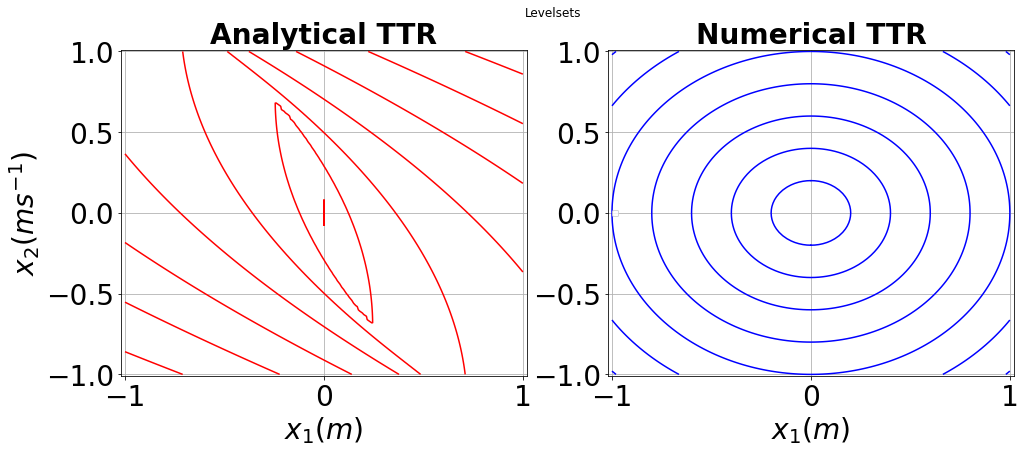

In [30]:
args = Bundle(dict(init_cond='circle', visualize=True, pause_time=1))
g, attr, value_func_init = preprocessing()
show_init_levels(g, attr, value_func_init)

#### Trajectories in the $x_1$-$x_2$ plane

\begin{align}
x_1 &= \xi_1 + \frac{1}{2} \Delta x_2^2 - \frac{1}{2} \Delta \xi_2^2, \text{ where } \quad t = \Delta(x_2 - \xi_2)  \\
x_2 &= \xi_2 + \Delta t
\end{align}

where $\Delta= u \equiv \pm 1$, 

$t$ is the time it takes to arrive at our goal; 

and $x_1$ and $x_2$ are the position and velocity of the body respectively.

In [81]:

fontdict = {'fontsize':28, 'fontweight':'bold'}
def show_trajectories(g, attr, x_i):
	### pick a bunch of initial conditions
	Δ = lambda u: u  # u is either +1 or -1
	
	# how much timesteps to consider
	t = np.linspace(-1, 1, 100)
	# do implicit euler integration to obtain x1 and x2
	x1p = np.empty((len(x_i), g.xs[0].shape[1], len(t)))
	x2p = np.empty((len(x_i), g.xs[1].shape[1], len(t)))
	# states under negative control law
	x1m  = np.empty((len(x_i), g.xs[0].shape[1], len(t)))
	x2m = np.empty((len(x_i), g.xs[1].shape[1], len(t)))

	fig, ax1 = plt.subplots(1, 1, figsize=(16,9))

	for i in range(len(x_i)):
		for k in range(len(t)):
			x2p[i, :,k] = x_i[i][1] + Δ(u_bound) * t[k]
			x1p[i, :,k] = x_i[i][0] + .5 * Δ(u_bound) * x2p[i,:,k]**2 - .5 * Δ(u_bound) * x_i[i][1]**2
			# state trajos under -ve control law
			x2m[i, :,k] = x_i[i][1] + Δ(-u_bound) * t[k]
			x1m[i, :,k] = x_i[i][0]+.3 + .5 * Δ(-u_bound) * x2p[i,:,k]**2 - .5 * Δ(-u_bound) * x_i[i][1]**2


	# Plot a few snapshots for different initial conditions.
	color = iter(plt.cm.inferno_r(np.linspace(.25, 1, 2*len(x_i))))
	# repeat for legends
	for init_cond in range(0, len(x_i)):
		# state trajectories are unique for every initial cond
		# here, we pick the last state
		ax1.plot(x1p[init_cond, -1, :], x2p[init_cond, -1, :], linewidth=3, color=next(color), \
			label=rf"x$_{init_cond+1}^+={x_i[init_cond]}$")
		ax1.plot(x1m[init_cond, -1, :], x2m[init_cond, -1, :], '-.', linewidth=3, color=next(color) , \
			label=rf"x$_{init_cond+1}^-={x_i[init_cond]}$")

		#plot the quivers
		ax1.grid('on')
		up, vp = x2p[init_cond, -1, ::len(t)//2], [Δ(u_bound)]*len(x2p[init_cond, -1, ::len(t)//2])
		um, vm = x2m[init_cond, -1, ::len(t)//2], [Δ(-u_bound)]*len(x2m[init_cond, -1, ::len(t)//2])
		ax1.quiver(x1p[init_cond, -1, ::len(t)//2], x2p[init_cond, -1, ::len(t)//2], up, vp, angles='xy', width=5e-3)
		ax1.quiver(x1m[init_cond, -1, ::len(t)//2], x2m[init_cond, -1, ::len(t)//2], um, vm, angles='xy', width=5e-3)

	ax1.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
	ax1.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
	ax1.tick_params(axis='both', which='major', labelsize=28)
	ax1.tick_params(axis='both', which='minor', labelsize=18)
	ax1.set_title(rf"State Trajectories.", fontdict=fontdict)
	ax1.legend(loc="center left", fontsize=14) 
	
	fig.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/doub_int_trajos.jpg"), 
                bbox_inches='tight',facecolor='None')
	# fig.canvas.draw()
	# fig.canvas.flush_events()
	time.sleep(args.pause_time)


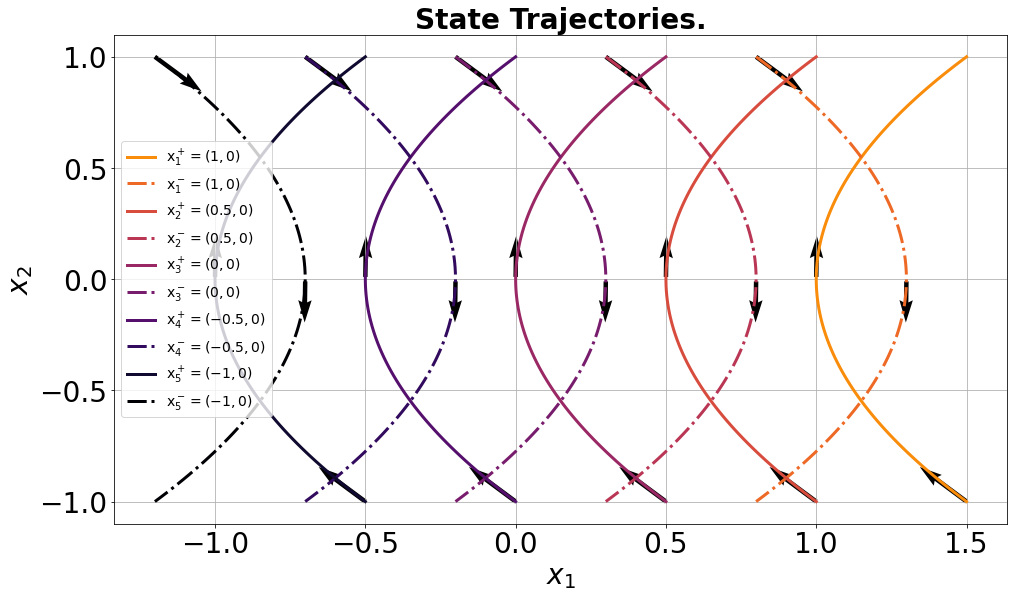

In [82]:

    xis = [(1,0), (.5, 0),  (0,0), (-.5, 0), (-1,0)]
    show_trajectories(g, attr, xis)

In [8]:
### Plot the switching curve
fontdict = {'fontsize':42, 'fontweight':'bold'}
def show_switch_curve():
	# Plot all vectograms(snapshots) in space and time.
	fig3, ax3 = plt.subplots(1, 1, figsize=(14,13))
	ax3.grid('on')
	color = iter(plt.cm.seismic_r(np.linspace(.25, 1, 4)))
	ax3.plot(dint.Gamma[0,:], linewidth=7.5, color=next(color), label=rf"Switching Curve, $\gamma$")
	xmin, xmax = ax3.get_xlim()
	ymin, ymax = ax3.get_ylim()
	ax3.hlines(0, xmin, xmax, colors='black', linestyles='solid', label='')
	ax3.vlines(len(dint.Gamma)//2, ymin, ymax, colors='black', linestyles='solid', label='')

	ax3.set_xlim(0, 100)
	ax3.set_ylim(-.55, .55)

	ax3.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
	ax3.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
	ax3.set_title(rf"Switching Curve, $\gamma$", fontdict=fontdict)
	ax3.tick_params(axis='both', which='major', labelsize=42)
	ax3.tick_params(axis='both', which='minor', labelsize=22)
	ax3.legend(fontsize=28)			
	plt.tight_layout()

	# fig.suptitle("The Double Integral Plant.", fontdict=fontdict)
	fig3.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/switching_curve.jpg"),
				bbox_inches='tight',facecolor='None')

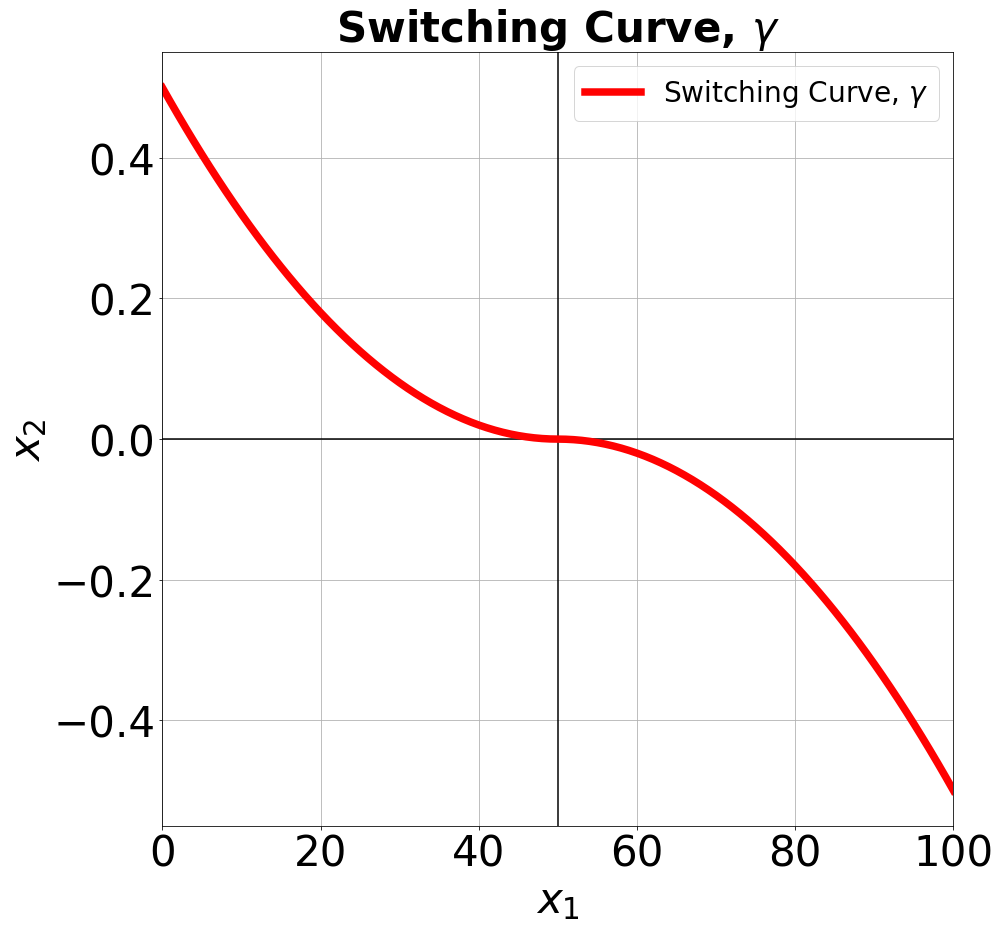

In [9]:
show_switch_curve()

### Plot the Analytical Time to Reach the origin


In [10]:
def show_attr():
    # Plot all vectograms(snapshots) in space and time.
    fig2, ax2 = plt.subplots(1, 1, figsize=(16,9))
    cdata = ax2.pcolormesh(g.xs[0], g.xs[1], attr, shading="nearest", cmap="magma_r")
    plt.colorbar(cdata, ax=ax2, extend="both")
    ax2.set_xlabel(rf"${{x}}_1$", fontdict=fontdict)
    ax2.set_ylabel(rf"${{x}}_2$", fontdict=fontdict)
    ax2.set_title(r"Reach Time", fontdict=fontdict)
    ax2.tick_params(axis='both', which='major', labelsize=28)
    ax2.tick_params(axis='both', which='minor', labelsize=18)

    # fig.suptitle("The Double Integral Plant.", fontdict=fontdict)
    fig2.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/attr.jpg"),
                bbox_inches='tight',facecolor='None')


### Examining the Level Sets

The analytical time-to-reach is resolved as

\begin{align}
  &\left[\left(x_2 + \sqrt{4 x_1 + 2 x_2^2}\right) \, \cdot \, \left(x_1 > \Gamma\right)\right] + 
            &\left[\left(-x_2 + \sqrt{2x_2^2 - 4 x_1}\right)  \, \cdot \,  (x_1 < \Gamma) \right] +
            |x_2|  \, \cdot \,  \left(x_1 = \Gamma\right).
\end{align}

where $\Gamma$ is the switching curve defined as 

\begin{align}
    \Gamma = -\dfrac{1}{2} \cdot x_2 \dot |x_2|
\end{align}

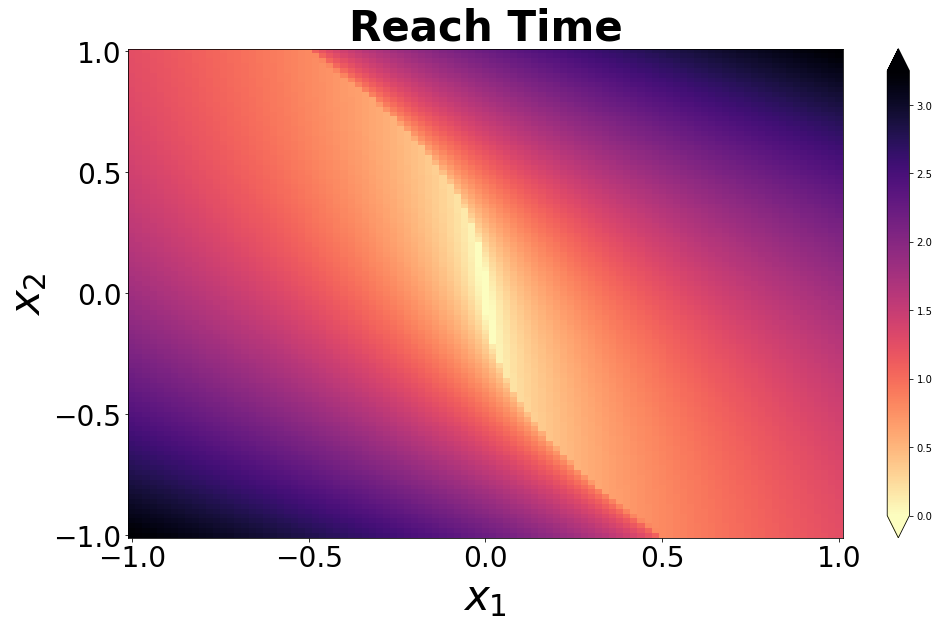

In [11]:
show_attr()

Let us consider the set of states that can be forced to the origin in the same minimum time $t^\star$. 

This is otherwise termed the _isochrones_ of the set $S(t^\star)$ at $t^\star$.

This is given by 

\begin{align}
   x_1 &= -\dfrac{1}{2} x_2^2 + \dfrac{1}{4}(t^\star - x_2)^2   \quad &for \quad x_1 > -\dfrac{1}{2} x_2 |x_2| \\
   x_1 &= -\dfrac{1}{2} x_2 - \dfrac{1}{4}(t^\star + x_2)^2   \quad &for \quad x_1 < -\dfrac{1}{2} x_2 |x_2| \\
   x_1 &= x_1 - \dfrac{1}{2} x_2 t^\star   \quad &for \quad x_1 = -\dfrac{1}{2} x_2 |x_2| 
\end{align}

### Optimize the trajectories

In [34]:
global dint, u_bound
#turn the state space over to the gpu
g.xs = [cp.asarray(x) for x in g.xs]
finite_diff_data = Bundle(dict(
            innerFunc = termLaxFriedrichs,
            innerData = Bundle({'grid':g,
                'hamFunc': dint.hamiltonian,
                'partialFunc': dint.dissipation,
                'dissFunc': artificialDissipationGLF,
                'derivFunc': upwindFirstENO2,
                }),
                positive = False,  # direction to grow the updated level set
            ))

small = 100*eps
t_span = np.linspace(0, 2.0, 20)
options = Bundle(dict(factorCFL=0.75, stats='on', maxStep=realmax, 						singleStep='off', postTimestep=postTimeStepTTR))

y = copy.copy(value_func_init.flatten())
y, finite_diff_data = postTimeStepTTR(0, y, finite_diff_data)
value_func = cp.asarray(copy.copy(y.reshape(g.shape)))

(101, 101) (101,) (101, 101)
min_rank  8


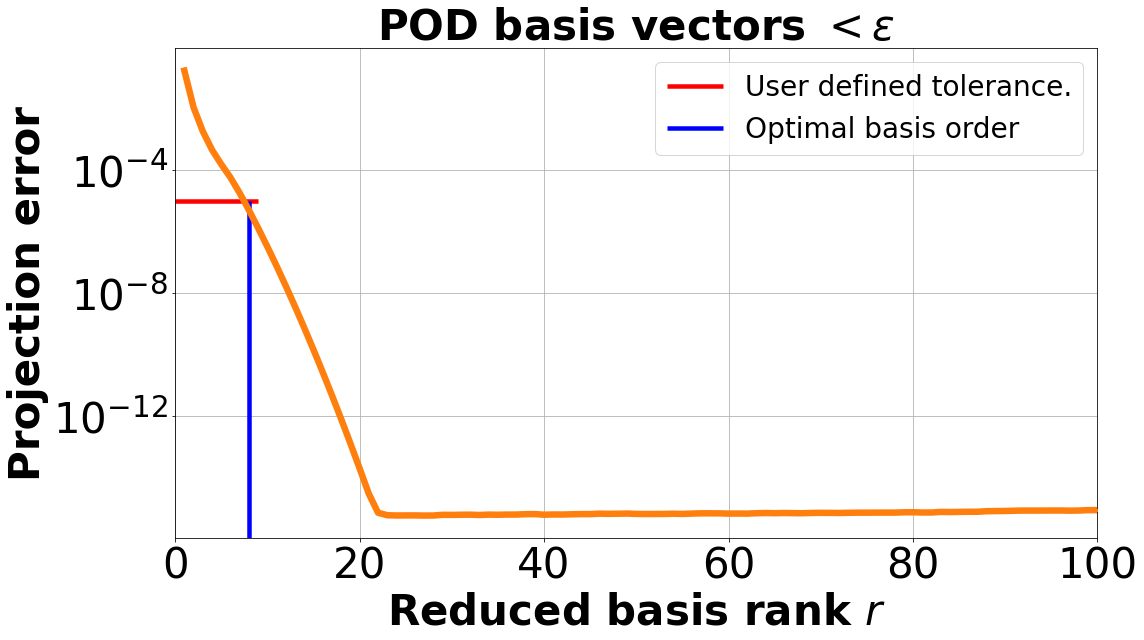

In [35]:
value_init = value_func_init

U, Sigma, V = la.svd(value_init, full_matrices=False)

# sanity checks
print(U.shape, Sigma.shape, V.shape)
np.allclose(U@np.diag(Sigma)@V, value_init)

# informed reduced basis rank
min_rank = minimal_projection_error(value_init, U, eps=1e-5, plot=True)
print('min_rank ', min_rank)

Ur, Sigmar, Vr = U[:,:min_rank], Sigma[:min_rank], V[:,:min_rank]
# be sure the singular values are arranged in descending order

# plt.plot(Sigmar)
f = plt.gcf()
ax = plt.gca()
ax.grid('on')
ax.set_title('POD basis vectors $<\epsilon$', fontdict=fontdict)
ax.set_xlabel(r"Reduced basis rank $r$", fontdict=fontdict)
ax.set_ylabel(r"Projection error", fontdict=fontdict)
ax.tick_params(axis='both', which='major', labelsize=42)
ax.tick_params(axis='both', which='minor', labelsize=22)
ax.legend(fontsize=28)			
plt.tight_layout()
f.savefig(join(expanduser("~"),"Documents/Papers/Safety/PGDReach", "figures/proj_error.jpg"),
            bbox_inches='tight',facecolor='None')


[9, 18, 22]

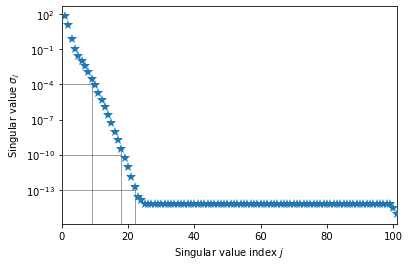

In [21]:
roi.pre.svdval_decay(Sigma, [1e-4, 1e-10, 1e-13], plot=True)

In [36]:

# project value function in reduced basis
value_rob = (Ur.T @ value_init).T
print(f'Value function in ROB: {value_rob.shape}')

Value function in ROB: (101, 8)


In [50]:
#construct the ttr on the reduced grid and fit a MLE with value_rob

value_rob = Ur.T @ value_init @ Ur

In [51]:

# calculate associated rhs functions on the reduced model
gmin = np.array(([[-1, -1]]),dtype=np.float64).T
gmax = np.array(([[1, 1]]),dtype=np.float64).T
gr = createGrid(gmin, gmax, np.array(([value_rob.shape])), None)

dint_rob = DoubleIntegratorROB(gr)
reduced_data = Bundle(dict(innerFunc = termLaxFriedrichs,
            innerData = Bundle({'grid':gr,
                'hamFunc': dint_rob.hamiltonian,
                'partialFunc': dint_rob.dissipation,
                'dissFunc': artificialDissipationGLF,
                'CoStateCalc': upwindFirstENO2,
                }),
                positive = False,  # we want to solve a min problem
            ))

y = copy.copy(value_rob.flatten())
y, reduced_data = postTimeStepTTR(0, y, reduced_data)
value_func = cp.asarray(copy.copy(y.reshape(gr.shape)))

In [52]:
### Reconstruct the problem on the lower grid using the attr on the V

AttributeError: 'numpy.ndarray' object has no attribute 'get'

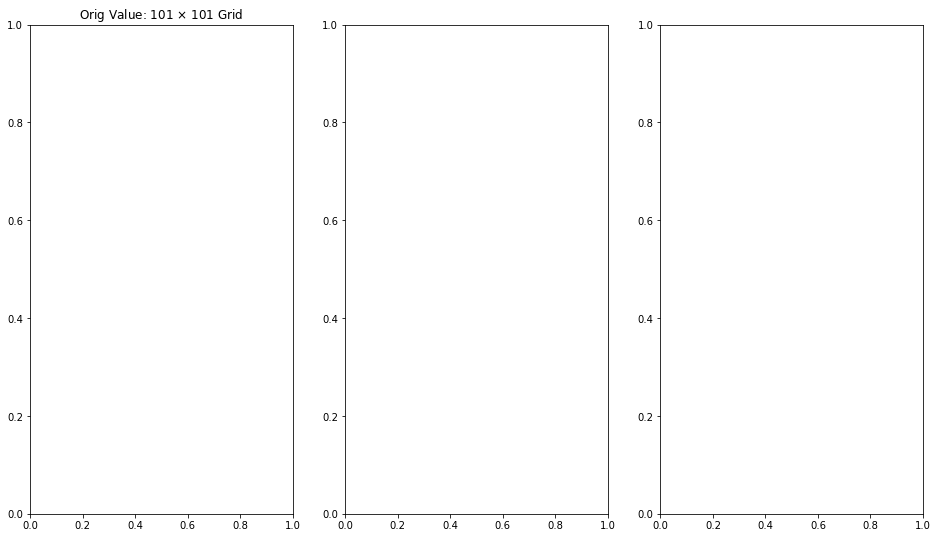

In [53]:
f, ax = plt.subplots(1,3, figsize=(16, 9))
ax = plt.subplot(131)
ax.set_title(rf'Orig Value: {value_init.shape[0]} $\times$ {value_init.shape[1]} Grid')
ax.contour(g.xs[0].get(), g.xs[1].get(), attr)


ax = plt.subplot(132)
mttr_red = dint_rob.mttr()
ax.contour(gr.xs[0], gr.xs[1], mttr_red)
ax.set_title(rf'ROM ATTR - {value_rob.shape[0]} $\times$ {value_rob.shape[1]} Grid')


ax = plt.subplot(133)
ax.contour(gr.xs[0], gr.xs[1], value_rob)
ax.set_title(rf'Projected ROM V - {value_rob.shape[0]} $\times$ {value_rob.shape[1]} Grid')

plt.show()

In [62]:
extent=(-1.5, 1.5, -1.5, 1.5)
len(extent)

4

No handles with labels found to put in legend.


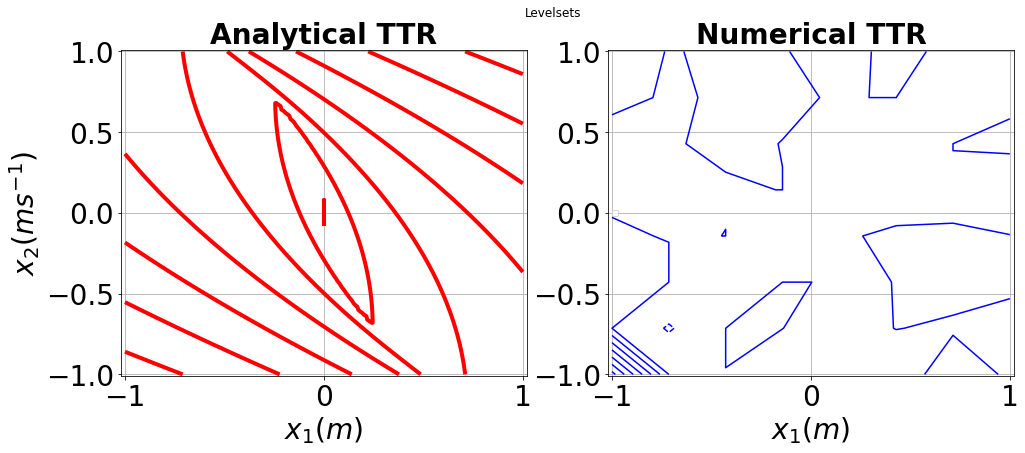

In [66]:
def controllability(g, gr, attr, value_func_init):
	fontdict = {'fontsize':28, 'fontweight':'bold'}
	f, (ax1, ax2) = plt.subplots(1,2,figsize=(16, 6))

	ax1.contour(g.xs[0], g.xs[1], attr, colors='red', linewidths=4, extent=(-3.5, 3.5, -1.5, 1.5))
	ax1.set_title('Analytical TTR', fontdict =fontdict)
	ax1.set_xlabel(r"$x_1 (m)$", fontdict =fontdict)
	ax1.set_ylabel(r"$x_2 (ms^{-1})$", fontdict =fontdict)
	ax1.tick_params(axis='both', which='major', labelsize=28)
	ax1.tick_params(axis='both', which='minor', labelsize=18)
	ax1.set_xlim([-1.02, 1.02])
	ax1.set_ylim([-1.01, 1.01])
	ax1.grid()

	ax2.contour(gr.xs[0], gr.xs[1], value_func_init, colors='blue')
	ax2.set_title('Numerical TTR', fontdict =fontdict)
	ax2.set_xlabel(r"$x_1 (m)$", fontdict =fontdict)
	ax2.set_xlim([-1.02, 1.02])
	ax2.set_ylim([-1.01, 1.01])
	ax2.grid('on')
	ax2.tick_params(axis='both', which='major', labelsize=28)
	ax2.tick_params(axis='both', which='minor', labelsize=18)
	ax2.legend(loc="center left", fontsize=8) 

	f.suptitle(f"Levelsets", fontdict =fontdict)

	f.canvas.draw()
	f.canvas.flush_events()
	time.sleep(args.pause_time)

controllability(g, gr, attr, value_rob)	

No handles with labels found to put in legend.


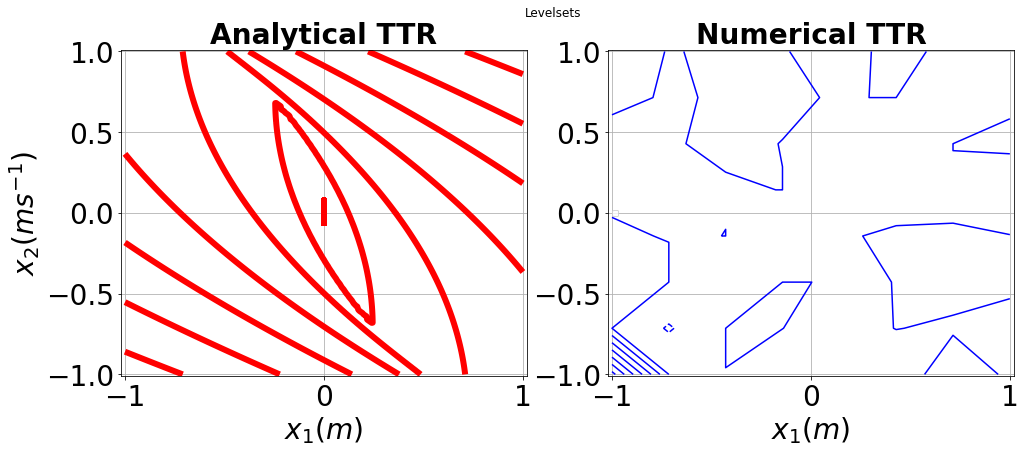

### Regress the Rob value function onto the grobal value

+ I tried to use a gaussian mixure model to parameterize the original value function

+ In trying to regress the value function on the reduced basis to the original value function; I got a little confused with the regression problem


In [ ]:
from Decomps.gmm import GMM
gmm_obj = GMM()
gmm_obj.update(value_init, 6)
# retrieve the mean variance and priors from the EM algo
mu, sigma = gmm_obj.mu.T, gmm_obj.sigma.T
weights = gmm_obj.clusterwts(value_init)
priors = np.exp(weights  ).T

# sanity check, mixing coefficients must sum to 1
assert np.allclose(np.sum(priors, axis=1), 1), "Mixing coefficients must sum to 1"

from matplotlib.patches import Ellipse

def add_ellipse(position, covariance, color, splot,):
    """Draw an ellipse with a given position and covariance"""
    v, w = spla.eigh(covar)
    v = 2.0 * np.sqrt(2.0) * np.sqrt(v)
    u = w[0] / spla.norm(w[0], 2)

    # Plot an ellipse to show the Gaussian component
    angle = np.arctan(u[1] / u[0])
    angle = 180.0 * angle / np.pi  # convert to degrees
    ell = Ellipse(mu, v[0], v[1], 180.0 + angle, color=color)
    ell.set_clip_box(splot.bbox)
    ell.set_alpha(0.5)

    return ell

splot = plt.subplot(1, 1, 1)
w_factor = 0.2 / weights.max()
color =  iter(plt.cm.rainbow_r(np.linspace(.25, 1, mu.shape[-1])))
for cidx in range(mu.shape[-1]):
    pos, covar, w = mu[:,cidx], sigma[:,:,cidx], weights[cidx]
    ell = add_ellipse(pos, covar, next(color), splot)    
    splot.add_artist(ell)

# plt.xlim(-9.0, 5.0)
# plt.ylim(-3.0, 6.0)
plt.xticks(())
plt.yticks(())
plt.title(f"GMM with {mu.shape[-1]} components", fontsize=(20))
plt.xlabel("U.A.")
plt.ylabel("U.A.")